In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import savgol_filter
from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles

In [2]:
# boilerplate stuff
import math
from collections.abc import Iterable

class RunningStats:
    def __init__(self):
        self.n = 0
        self.old_m = 0
        self.new_m = 0
        self.old_s = 0
        self.new_s = 0

    def clear(self):
        self.n = 0

    def push(self, x):
        if isinstance(x, Iterable):
            for v in x:
                self.push(v)
            return

        self.n += 1

        if self.n == 1:
            self.old_m = self.new_m = x
            self.old_s = 0
        else:
            self.new_m = self.old_m + (x - self.old_m) / self.n
            self.new_s = self.old_s + (x - self.old_m) * (x - self.new_m)

            self.old_m = self.new_m
            self.old_s = self.new_s

    def mean(self):
        return self.new_m if self.n else 0.0

    def variance(self):
        return self.new_s / (self.n - 1) if self.n > 1 else 0.0

    def standard_deviation(self):
        return math.sqrt(self.variance())

    def __repr__(self):
        return f'n: {self.n}, mean: {self.mean()}, var: {self.variance()}, sd: {self.standard_deviation()}'
    
def standardize_signal(x, trim_zeros=True):
    if trim_zeros:
        x_in = np.trim_zeros(x)
    else:
        x_in = x
    rs = RunningStats() # numpy.std goes to inf so do it by hand
    rs.push(x_in)
    return (x - rs.mean()) / rs.standard_deviation()

In [3]:
dataset_choice='SANDBOX_NO_VARIATIONS'
file_loc='../../../moxie/data/processed/pedestal_profiles_ML_READY_ak_5052022_uncerts_mask.pickle'
with open(file_loc, 'rb') as file:
    massive_dict = pickle.load(file)
full_dict = massive_dict[dataset_choice]
massive_dict = {}

profiles, rmids, ids, uncerts = full_dict['all_dict']['raw']['profiles'], full_dict['all_dict']['raw']['real_space_radii'], full_dict['all_dict']['raw']['pulse_time_ids'], full_dict['all_dict']['raw']['uncerts']


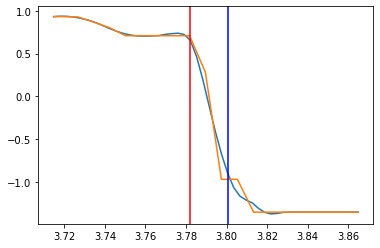

3.7821415005897987 3.800522872379848


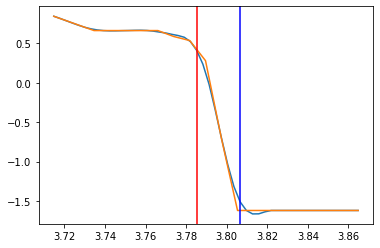

3.7851917500398597 3.8066387273827376


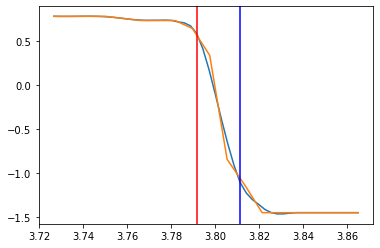

3.7915336842439613 3.811273346141893


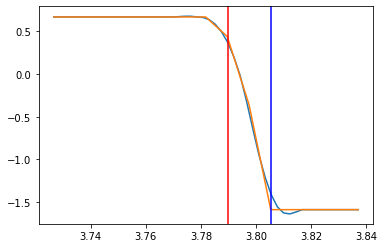

3.7897419248308455 3.805511031832014


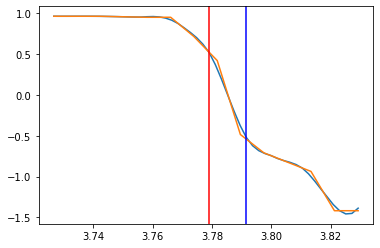

3.7790013576040464 3.791562708056703


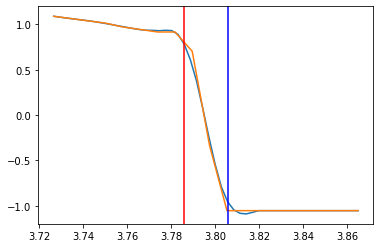

3.785876137869699 3.8056179455348422


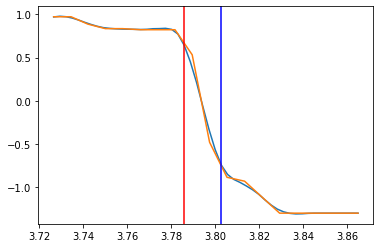

3.78587760244097 3.8027986847624486


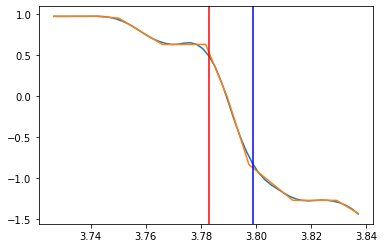

3.7829654070795797 3.7987349227983125


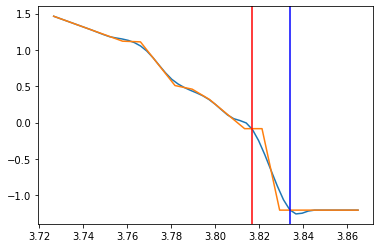

3.816895373013555 3.833817185187826


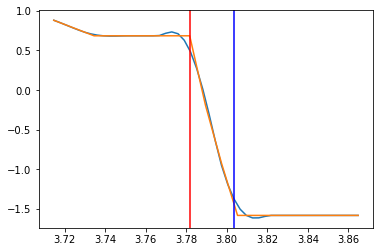

3.782094274248396 3.803541932787214


In [5]:
def pedestal_top(p_old, x, plot_result=False):
        # standardize signal
        p = standardize_signal(p_old, trim_zeros=True)
        
        # interp signal to Nx=50
        f_interp = interpolate.interp1d(x, p)
        x_h = np.linspace(x[0], x[-1], 50)  # interpolate to 50 (evenly spaced) points
        p_h = f_interp(x_h)

        # smooth with savgol filter
        p_s = savgol_filter(p_h, window_length=11, polyorder=3)

        # get max gradient so we're in the pedestal
        p_s_grad = np.gradient(p_s)
        min_i = np.argmin(p_s_grad)
        
        
        # search from pedestal region outward in 2nd derivatives
        p_s_grad2 = np.gradient(p_s_grad)
        p_s_grad2 = savgol_filter(p_s_grad2, window_length=11, polyorder=3)  # aggressively smooth as well
        p_s_grad2 = standardize_signal(p_s_grad2, trim_zeros=True)
        # standardize s.t. if we go >1 sd up/down, we stop searching
        
        # go to the left from middle point
        sd_cutoff = -.5
        start_cut_early = False  # if we go < -1 for x'', mark as such, such that if we go > -1 again we stop looking
        min_val = p_s_grad2[min_i]
        top_i = min_i
        for i in reversed(range(0, min_i)):
            if p_s_grad2[i] < min_val:
                min_val = p_s_grad2[i]
                top_i = i
                if min_val < sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] > sd_cutoff:
                break
        
        # found our x for top
        # same procedure for bottom
        sd_cutoff = .5
        start_cut_early = False  # if we go > 1 for x'', etc.
        max_val = p_s_grad2[min_i]
        bottom_i = min_i
        
        for i in range(min_i+1, x_h.shape[0]):
            if p_s_grad2[i] > max_val:
                max_val = p_s_grad2[i]
                bottom_i = i
                if max_val > sd_cutoff:
                    start_cut_early = True
            elif start_cut_early and p_s_grad2[i] < sd_cutoff:
                break
        
        top, bottom = x_h[top_i], x_h[bottom_i]
        top_left_one = x_h[top_i - 1]
        
        if plot_result:
            plt.plot(x_h, p_s)
            plt.plot(x, p)
            plt.axvline(top, color='red')
            plt.axvline(bottom, color='blue')
            plt.show()
        return top, bottom

# grab example data
for idx in range(10):
    original = profiles[idx][0], profiles[idx][1],uncerts[idx][0], uncerts[idx][1], rmids[idx]
    ne, te, dne, dte, x = original
    new_ne, new_te =  np.minimum.accumulate(ne), np.minimum.accumulate(te)
    keep_idx = np.where(new_te == te)
    
    ne, te, dne, dte, x = new_ne[keep_idx], new_te[keep_idx], dne[keep_idx], dte[keep_idx], x[keep_idx]
    # logical_bool_mask = te < 700
    logical_bool_mask = np.logical_and(ne > 0, te > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dte > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dne > 0)
    logical_bool_mask = np.logical_and(logical_bool_mask, dte < 3000)
    
    # x = train_radii[i][mask]
    # te = dataset['all_dict']['raw']['profiles'][idx][0]
    
    top_x, bottom_x = pedestal_top(ne, x, plot_result=True)
    print(top_x, bottom_x)
